In [ ]:
from diff_predictor import data_process, predxgboost, spatial
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 

from os import listdir, getcwd, chdir
from os.path import isfile, join
import os
from sklearn.preprocessing import scale, StandardScaler
from numpy.random import permutation


from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, recall_score, precision_score, f1_score
import operator
import xgboost as xgb
import shap
from xgboost.training import CVPack
from xgboost import callback
from xgboost.core import CallbackEnv
from xgboost.core import EarlyStopException
from xgboost.core import STRING_TYPES



In [4]:
workbookDir = getcwd()

print('Current Notebook Dir: ' + workbookDir)
chdir(workbookDir) # Go to current workbook Dir"
chdir('..')        # Go up one
chdir('..') 
chdir('..')        # Go up one
print(f'Using current directory for loading data: {getcwd()}')
workbookDir = getcwd()

Current Notebook Dir: /Users/nelsschimek/Documents/nancelab/diff_predictor
Using current directory for loading data: /Users/nelsschimek


In [13]:
#age_feature_path = workbookDir + '/data/raw_data_age/'
age_feature_path = '/Users/nelsschimek/Documents/nancelab/Data/feature_data_age/'
age_feature_filelist = [f for f in listdir(age_feature_path) if isfile(join(age_feature_path, f)) and 'feat' in f]
print(len(age_feature_filelist))

75


In [14]:
fstats_tot_age = data_process.generate_fullstats(age_feature_path, age_feature_filelist, ['P14','P35', 'P70'], 'age')

Adding file features_P70_40nm_s3_v3.csv size: (2322, 67)
Adding file features_P14_40nm_s3_v3.csv size: (323, 91)
Adding file features_P35_brain_2_slice_1_vid_4.csv size: (878, 91)
Adding file features_P35_brain_2_slice_1_vid_5.csv size: (467, 91)
Adding file features_P14_40nm_s3_v2.csv size: (243, 91)
Adding file features_P70_40nm_s3_v2.csv size: (1401, 67)
Adding file features_P14_40nm_s1_v5.csv size: (268, 91)
Adding file features_P70_40nm_s1_v5.csv size: (17, 67)
Adding file features_P14_40nm_s3_v1.csv size: (151, 91)
Adding file features_P70_40nm_s1_v4.csv size: (21, 67)
Adding file features_P70_40nm_s3_v1.csv size: (2625, 67)
Adding file features_P14_40nm_s1_v4.csv size: (140, 91)
Adding file features_P70_40nm_s3_v5.csv size: (4162, 67)
Adding file features_P35_brain_2_slice_1_vid_2.csv size: (833, 91)
Adding file features_P14_40nm_s3_v5.csv size: (389, 91)
Adding file features_P14_40nm_s3_v4.csv size: (113, 91)
Adding file features_P35_brain_2_slice_1_vid_3.csv size: (1017, 91)
A

In [15]:
feature_list = [
    'alpha', # Fitted anomalous diffusion alpha exponenet
    'D_fit', # Fitted anomalous diffusion coefficient
    'kurtosis', # Kurtosis of track
    'asymmetry1', # Asymmetry of trajecory (0 for circular symmetric, 1 for linear)
    'asymmetry2', # Ratio of the smaller to larger principal radius of gyration
    'asymmetry3', # An asymmetric feature that accnts for non-cylindrically symmetric pt distributions
    'AR', # Aspect ratio of long and short side of trajectory's minimum bounding rectangle
    'elongation', # Est. of amount of extension of trajectory from centroid
    'boundedness', # How much a particle with Deff is restricted by a circular confinement of radius r
    'fractal_dim', # Measure of how complicated a self similar figure is
    'trappedness', # Probability that a particle with Deff is trapped in a region
    'efficiency', # Ratio of squared net displacement to the sum of squared step lengths
    'straightness', # Ratio of net displacement to the sum of squared step lengths
    'MSD_ratio', # MSD ratio of the track
#     'frames', # Number of frames the track spans
    'Deff1', # Effective diffusion coefficient at 0.33 s
    'Deff2', # Effective diffusion coefficient at 3.3 s
    #'angle_mean', # Mean turning angle which is counterclockwise angle from one frame point to another
    #'angle_mag_mean', # Magnitude of the turning angle mean
    #'angle_var', # Variance of the turning angle
    #'dist_tot', # Total distance of the trajectory
    #'dist_net', # Net distance from first point to last point
    #'progression', # Ratio of the net distance traveled and the total distance
    'Mean alpha', 
    'Mean D_fit', 
    'Mean kurtosis', 
    'Mean asymmetry1', 
    'Mean asymmetry2',
    'Mean asymmetry3', 
    'Mean AR',
    'Mean elongation', 
    'Mean boundedness',
    'Mean fractal_dim', 
    'Mean trappedness', 
    'Mean efficiency',
    'Mean straightness', 
    'Mean MSD_ratio', 
    'Mean Deff1', 
    'Mean Deff2',
    ]

target = 'age'

In [16]:
ecm = fstats_tot_age[feature_list + [target, 'Track_ID', 'X', 'Y']] #dont think i need these rn
print(ecm.shape)
ecm = ecm[~ecm[list(set(feature_list) - set(['Deff2', 'Mean Deff2']))].isin([np.nan, np.inf, -np.inf]).any(1)]       # Removing nan and inf data points
ecm.shape

(38790, 36)


(33737, 36)

In [17]:
def full_preprocess(ecm, balanced=True, y_scramble=False, target=None):

    rand_state = np.random.randint(1, 2000)
    if balanced:
        bal_ecm = data_process.balance_data(ecm, target, random_state=rand_state)
        bal_ecm = bal_ecm.reset_index(drop=True)
        #sampled_df = bal_ecm.sample(frac=0.5)
        sampled_df = data_process.bin_data(bal_ecm)
    else:
        sampled_df = data_process.bin_data(ecm)
    label_df = sampled_df[target]
    features_df = sampled_df.drop([target, 'X', 'Y', 'binx', 'biny', 'bins', 'Track_ID'], axis=1)
    features = features_df.columns

    if y_scramble:
        perm = permutation(len(label_df))
        label_shuffled = label_df[perm]
        le = preprocessing.LabelEncoder()
        sampled_df['encoded_target'] = le.fit_transform(label_shuffled)
    else:
        le = preprocessing.LabelEncoder()
        sampled_df['encoded_target'] = le.fit_transform(sampled_df[target])

    seed = rand_state
    np.random.seed(seed)
    train_split = 0.7
    test_split = 0.5


    training_bins = np.random.choice(sampled_df['bins'].unique(), int(len(sampled_df['bins'].unique())*train_split), replace=False)

    X_train = sampled_df[sampled_df['bins'].isin(training_bins)]
    X_test_val = sampled_df[~sampled_df['bins'].isin(training_bins)]
    X_val, X_test = train_test_split(X_test_val, test_size=test_split, random_state=seed)

    y_train = X_train['encoded_target']
    y_test = X_test['encoded_target']
    y_val = X_val['encoded_target']

    dtrain = xgb.DMatrix(X_train[features], label=y_train)
    dtest = xgb.DMatrix(X_test[features], label=y_test)
    dval = xgb.DMatrix(X_val[features], label=y_val)
    return dtrain, dtest, dval, X_train, X_test, y_train, y_test, le



In [18]:
param = {'max_depth': 3,
         'eta': 0.005,
         'min_child_weight': 0,
         'verbosity': 0,
         'objective': 'multi:softprob',
         'num_class': 3,
         'silent': 'True',
         'gamma': 5,
         'subsample': 0.15,
         'colsample_bytree': 0.8,
         'eval_metric': "mlogloss",
#          # GPU integration will cut time in ~half:
#          'gpu_id' : 0,
#          'tree_method': 'gpu_hist',
#          'predictor': 'gpu_predictor'
         }

In [19]:
bal_ecm = data_process.balance_data(ecm, target, random_state=1)
bal_ecm = data_process.bin_data(bal_ecm, resolution=128)
label_df = bal_ecm[target]
features_df = bal_ecm.drop([target, 'Track_ID', 'X', 'Y', 'binx', 'biny', 'bins'], axis=1)
features = features_df.columns

# Regular split

seed = 1234
np.random.seed(seed)
train_split = 0.8
test_split = 0.5

le = preprocessing.LabelEncoder()
bal_ecm['encoded_target'] = le.fit_transform(bal_ecm[target])

training_bins = np.random.choice(bal_ecm.bins.unique(), int(len(bal_ecm.bins.unique())*train_split), replace=False)

X_train = bal_ecm[bal_ecm.bins.isin(training_bins)]
X_test_val = bal_ecm[~bal_ecm.bins.isin(training_bins)]
X_val, X_test = train_test_split(X_test_val, test_size=test_split, random_state=seed)

y_train = X_train['encoded_target']
y_test = X_test['encoded_target']
y_val = X_val['encoded_target']

# dtrain = X_train[features]
# dtest = X_test[features]
# dval = X_val[features]

dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)
dval = xgb.DMatrix(X_val[features], label=y_val)

Ratio before data balance (P70:P14:P35) = 13968:4900:14869
Ratio after balance (P70:P14:P35) = 4900:4900:4900


In [20]:
best_param = {'max_depth': 4, 'eta': 0.1, 'min_child_weight': 1, 'verbosity': 0, 'objective': 'multi:softprob', 'num_class': 3, 'silent': 'True', 'gamma': 1.0, 'subsample': 0.5, 'colsample_bytree': 0.6, 'eval_metric': 'mlogloss'}

In [21]:
# Currently using parameters found in the diff_mode analysis notebook for age
booster, acc, true_label, preds = predxgboost.train(best_param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=804, verbose=False)


Accuracy: 0.8615384615384616


In [22]:
class_names = le.classes_
class_results = classification_report(true_label, preds, digits=4, target_names = class_names)
print(str(class_results))

              precision    recall  f1-score   support

         P14     0.9153    0.8644    0.8891       450
         P35     0.7843    0.8282    0.8056       483
         P70     0.8949    0.8913    0.8931       497

    accuracy                         0.8615      1430
   macro avg     0.8649    0.8613    0.8626      1430
weighted avg     0.8640    0.8615    0.8623      1430



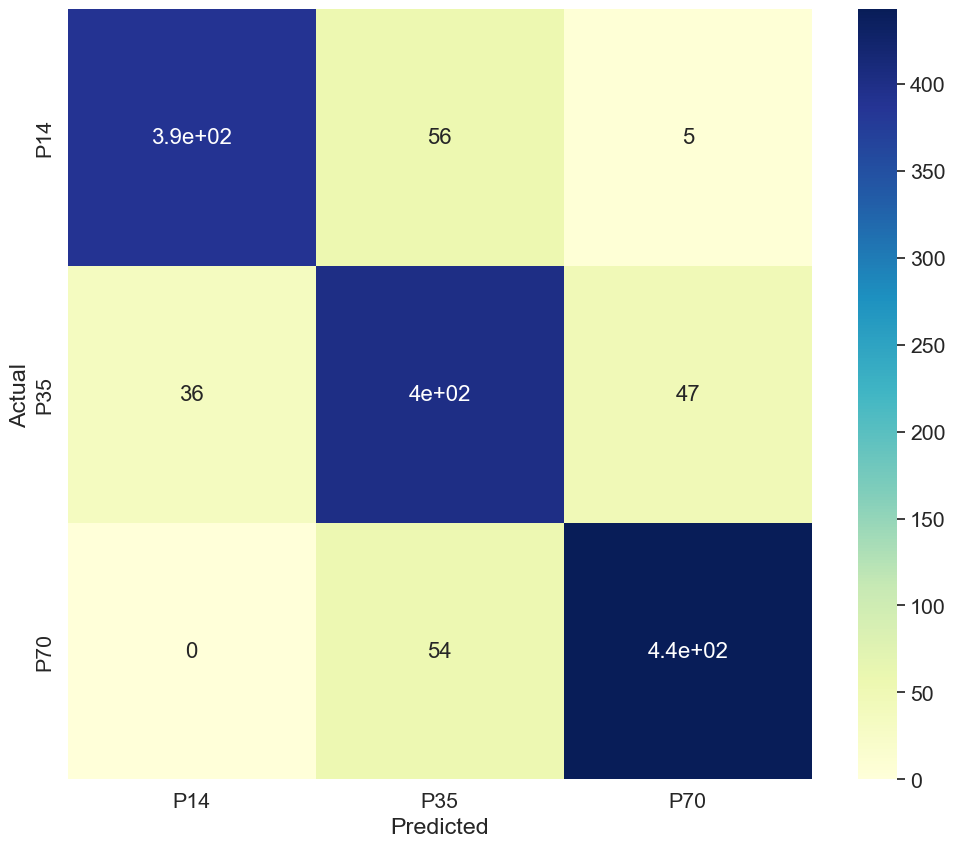

In [23]:
metrics.confusion_matrix(y_test, preds)
plt.figure(figsize=(12,10))
cm_array = metrics.confusion_matrix(true_label, preds)
df_cm = pd.DataFrame(cm_array, index = class_names, columns = class_names)

sns.set(font_scale=1.4) # for label size
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu")
ax.set(xlabel='Predicted', ylabel='Actual')

plt.show()

In [24]:
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_test[features])

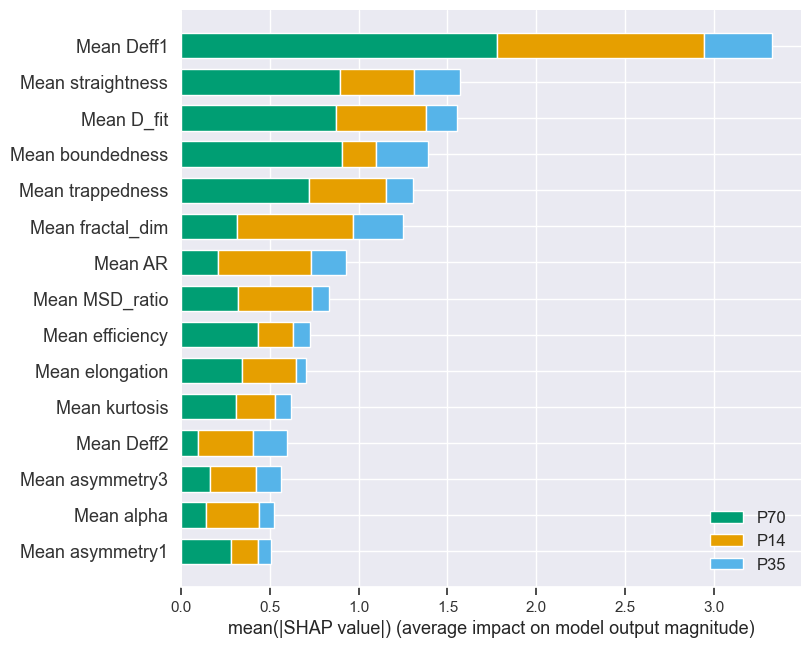

In [25]:
from matplotlib import colors as plt_colors

explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_test[features])
c_NT = '#E69F00'
c_HYase = '#56B4E9'
c_ChABC = '#009E73'

colors = [c_NT, c_HYase, c_ChABC]
class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(len(shap_values))])
cmap = plt_colors.ListedColormap(np.array(colors)[class_inds])
shap.summary_plot(shap_values, X_test[features], class_names=np.array(class_names), max_display=15, title='Total SHAP Values', color=cmap)

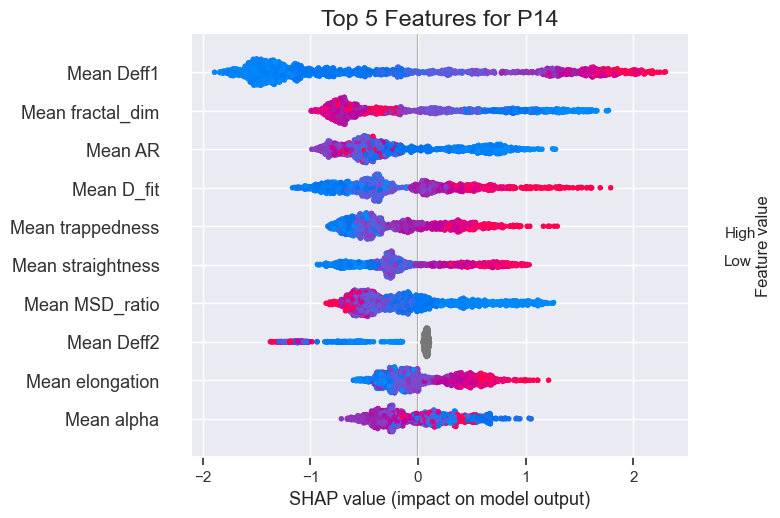

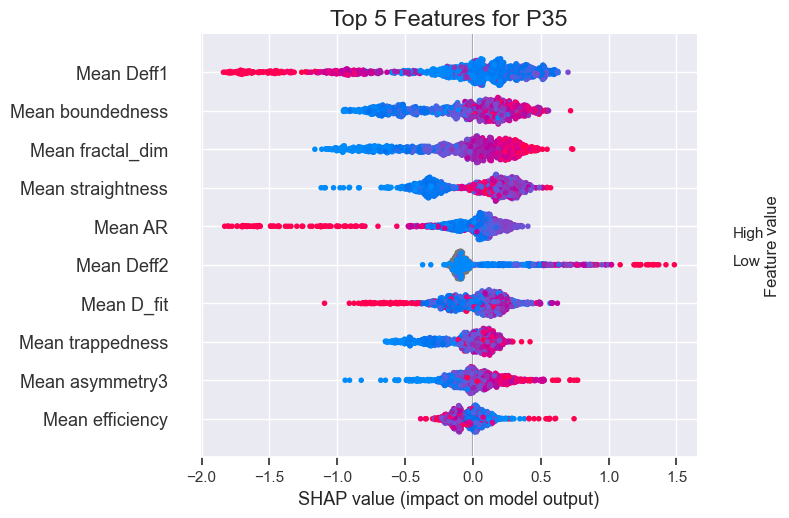

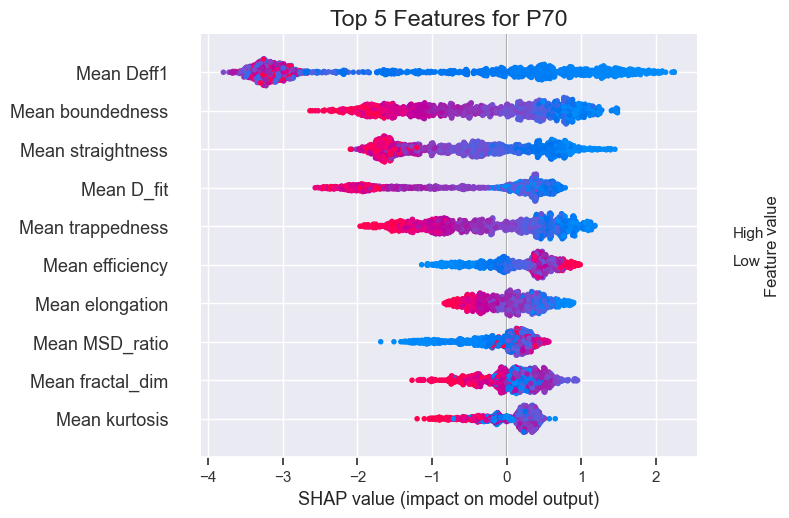

In [27]:
for i in range(3): 
    figsize = (7.5, 5)
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    shap.summary_plot(shap_values[i], X_test[feature_list], max_display=10, show=False)
    ax.set_title(f'Top 5 Features for {le.classes_[i]}')

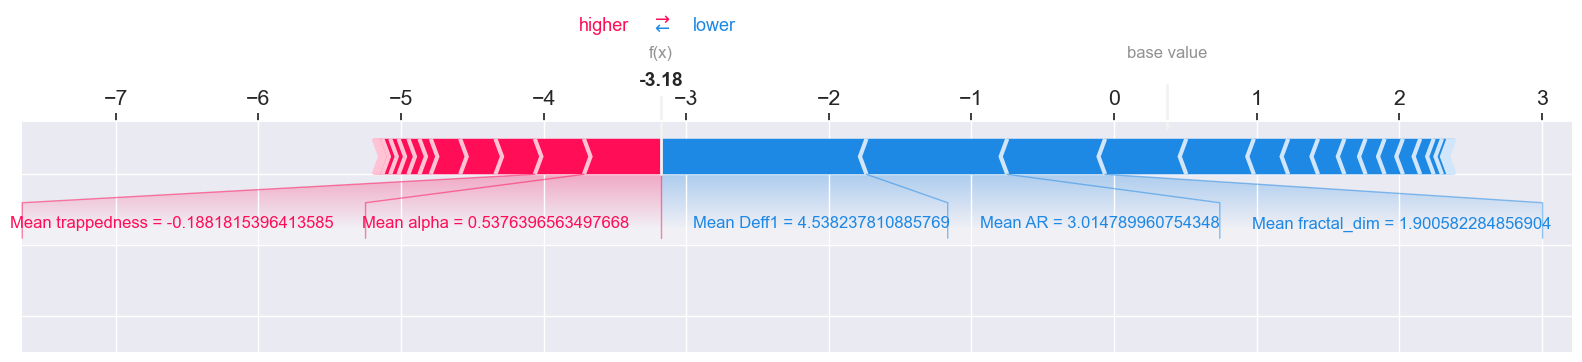

In [37]:
shap.force_plot(explainer.expected_value[2], shap_values[0][0,:], X_test[features].iloc[0,:], matplotlib=True, show=False)

In [49]:
shap_values[3].shape

IndexError: list index out of range

alpha
D_fit
kurtosis
asymmetry1
asymmetry2
asymmetry3
AR
elongation
boundedness
fractal_dim
trappedness
efficiency
straightness
MSD_ratio
Deff1
Deff2
Mean alpha


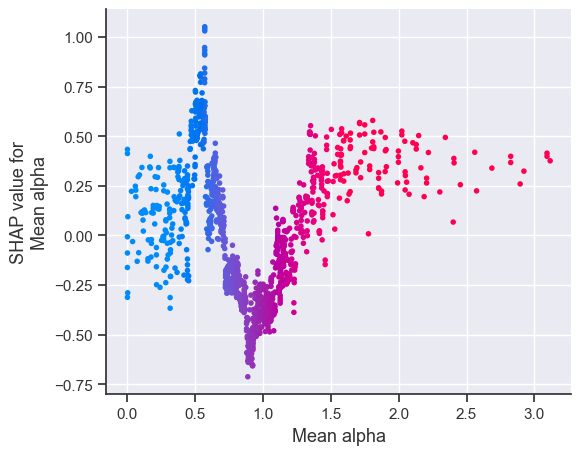

Mean D_fit


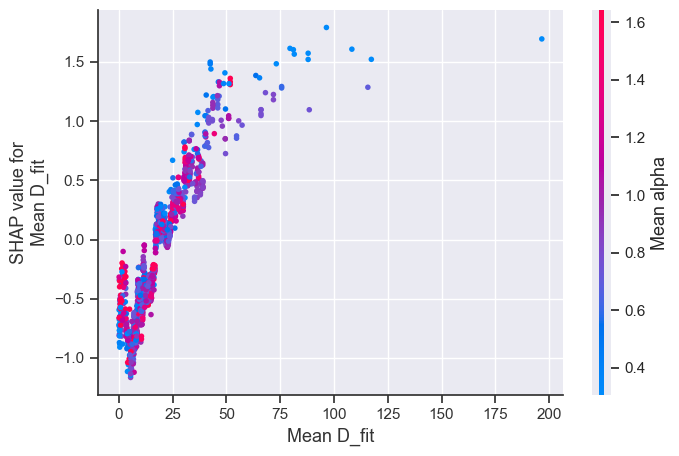

Mean kurtosis


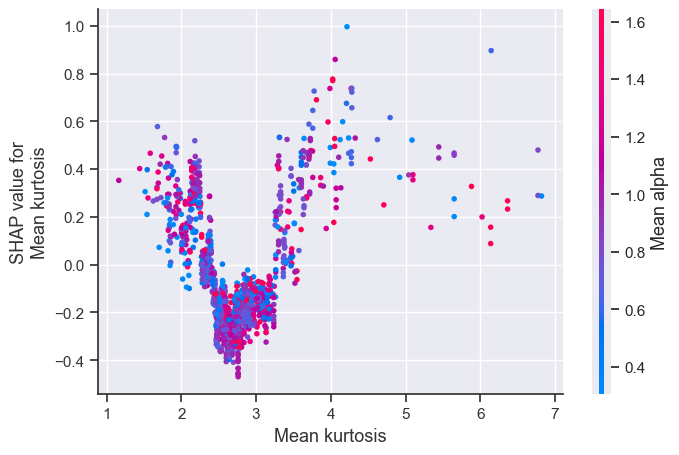

Mean asymmetry1


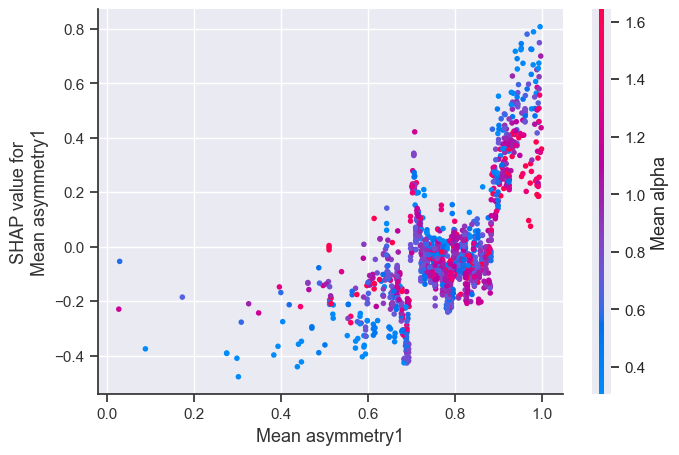

Mean asymmetry2


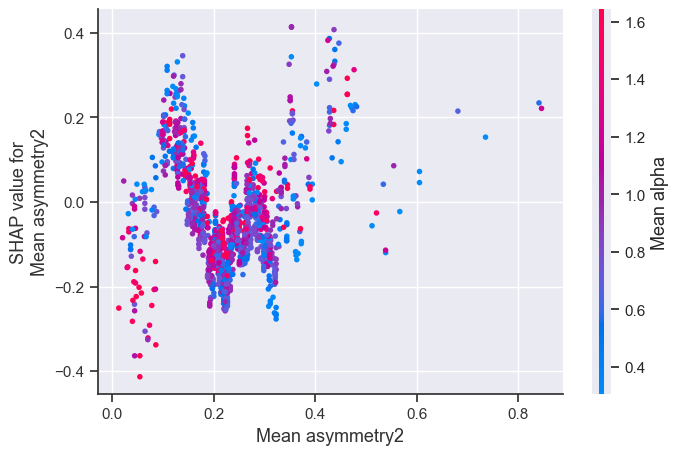

Mean asymmetry3


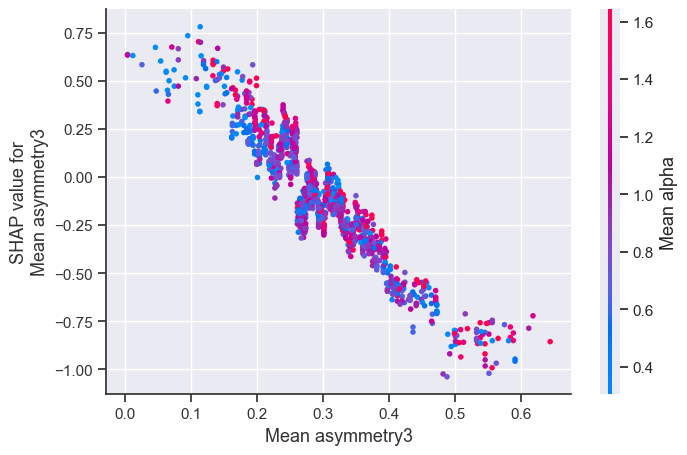

Mean AR


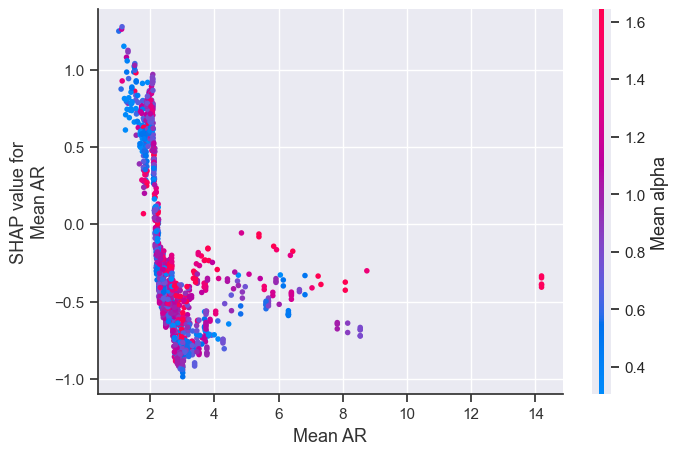

Mean elongation


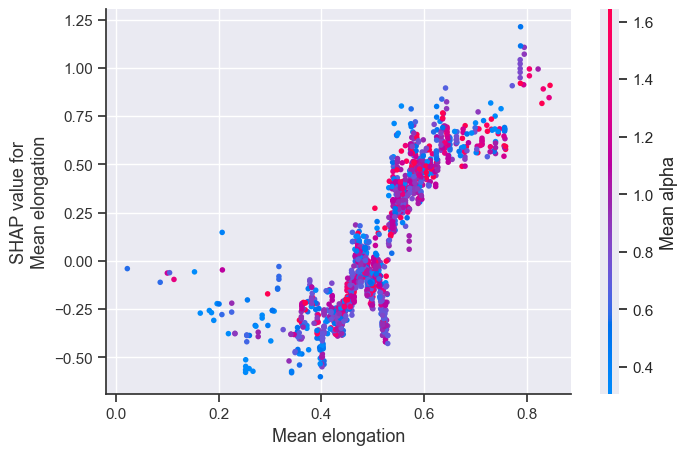

Mean boundedness


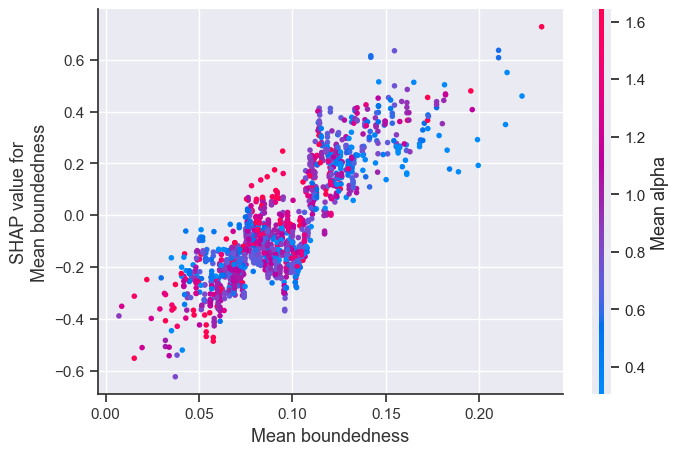

Mean fractal_dim


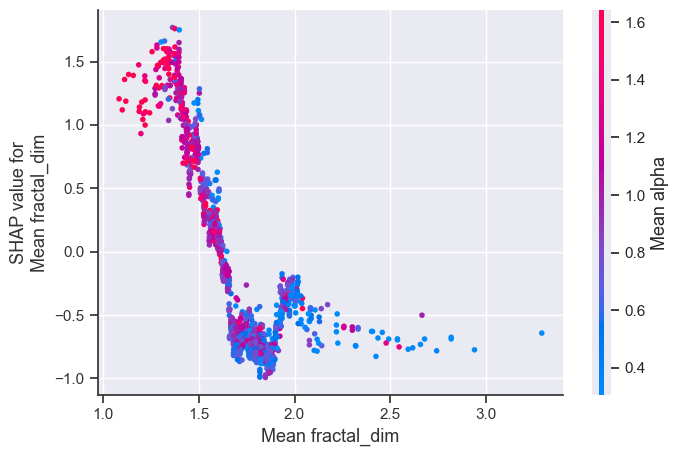

Mean trappedness


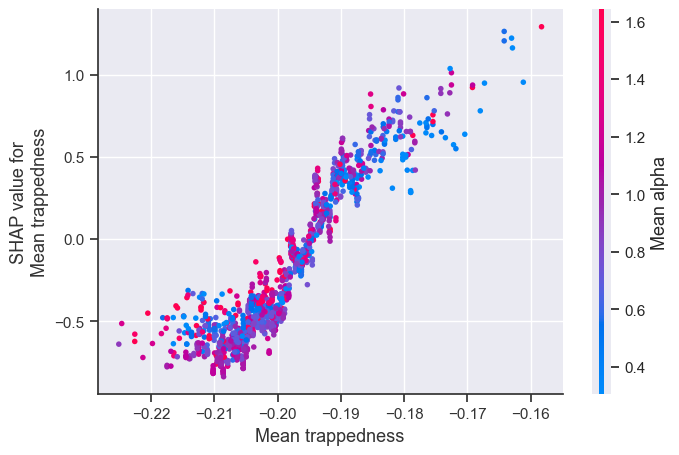

Mean efficiency


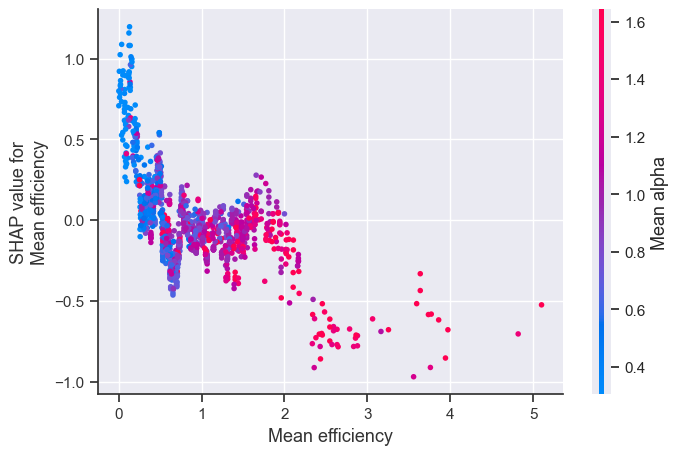

Mean straightness


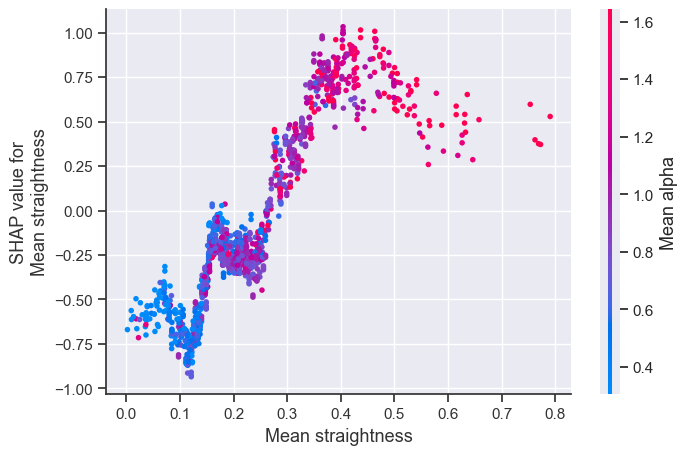

Mean MSD_ratio


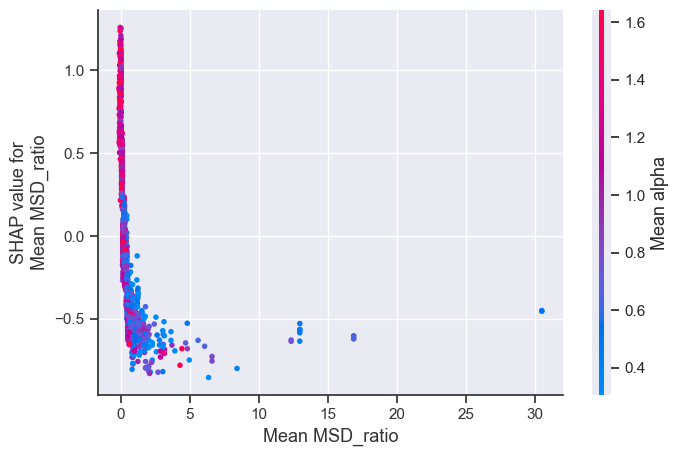

Mean Deff1


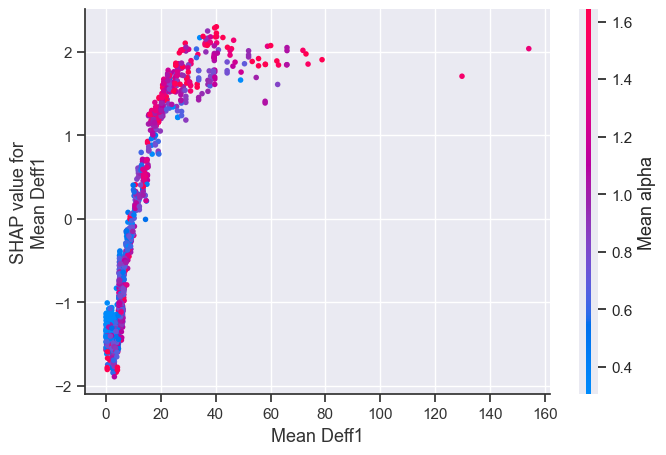

Mean Deff2


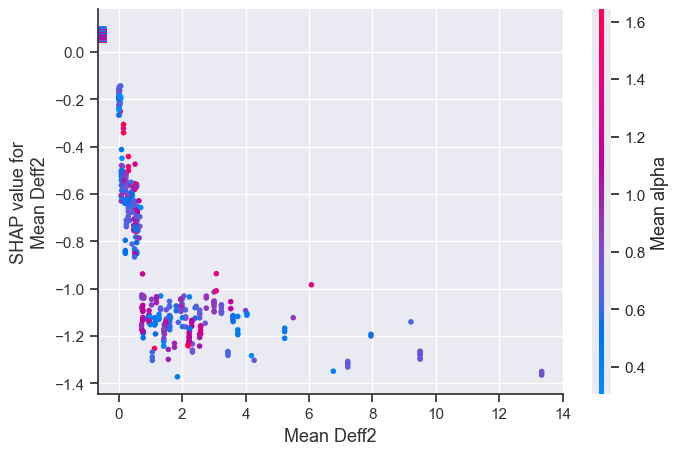

In [61]:
for name in X_train[features].columns:
    print(name)
    if 'Mean' in name:
        shap.dependence_plot(ind=name, shap_values=shap_values[0], features=X_test[features], interaction_index='Mean alpha')

In [58]:
shap_interaction_values = explainer.shap_interaction_values(X_test[features])